# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [2]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNet152_Weights.IMAGENET1K_V2
model = models.resnet152(weights=weights)
transforms = weights.transforms()

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\tomas/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:03<00:00, 61.2MB/s] 


## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [3]:
# Normalize images
data_aug = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

data_in = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [4]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:30]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 6479
Number of valid images: 2192
Number of test images: 2129


In [5]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 15
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([15, 224, 224, 3])
tensor([12, 12, 12,  1,  1,  5, 12, 12, 12,  0,  0,  3, 12,  0,  0, 12,  0, 12,
        12, 12, 12,  0,  2,  0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,
        12, 12, 12, 12,  4,  6,  6, 12,  6,  8, 12,  6,  6, 12, 12, 12,  9, 10,
         6, 12,  7, 12, 12, 12,  7, 11, 12, 12])
tensor([[12, 12, 12,  1,  1,  5, 12, 12],
        [12,  0,  0,  3, 12,  0,  0, 12],
        [ 0, 12, 12, 12, 12,  0,  2,  0],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12,  6, 12, 12, 12, 12],
        [ 4,  6,  6, 12,  6,  8, 12,  6],
        [ 6, 12, 12, 12,  9, 10,  6, 12],
        [ 7, 12, 12, 12,  7, 11, 12, 12]])


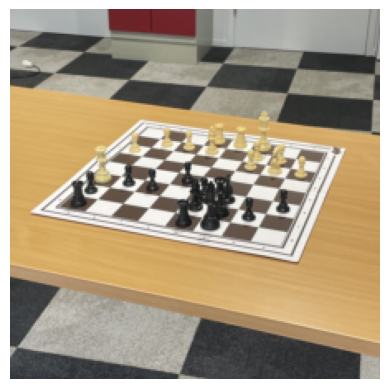

torch.Size([15, 224, 224, 3])
tensor([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0, 12,  0, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  8,  9, 11, 10,  9,  8,  7])
tensor([[ 1,  2,  3,  5,  4,  3,  2,  1],
        [ 0,  0,  0,  0,  0,  0, 12,  0],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12,  0, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [ 6,  6,  6,  6,  6,  6,  6,  6],
        [ 7,  8,  9, 11, 10,  9,  8,  7]])


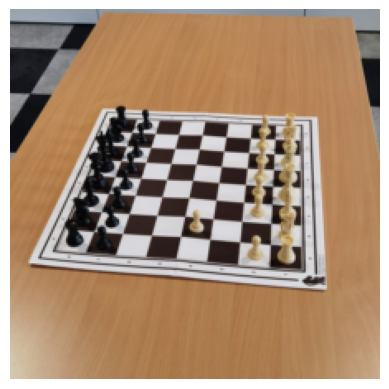

In [6]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels[0])
    print(labels[0].reshape(8, 8))
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break
for batch in test_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels[1])
    print(labels[1].reshape(8, 8))
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[1])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, 64),
    nn.Sigmoid()
)
# black 
model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train the model

Define function to perform one iteration

In [8]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score

def calculate_chess_accuracy(y_true, y_pred):
    """
    Calculate chess board accuracy metrics
    Args:
        y_true: Ground truth (batch_size, 64)
        y_pred: Model predictions (batch_size, 64)
    Returns:
        overall_acc: Total accuracy across all squares
        square_acc: List of accuracies per square
    """
    # Convert -0 to 0 (equivalent in floating point)
    y_true = np.where(y_true == -0., 0., y_true)
    y_pred = np.where(y_pred == -0., 0., y_pred)
    
    # Binarize predictions if using raw outputs
    y_pred = (y_pred > 0.5).astype(float)
    
    # Calculate overall accuracy (all squares combined)
    overall_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
    
    # Calculate accuracy per square
    square_acc = []
    for square_idx in range(64):
        acc = accuracy_score(y_true[:, square_idx], y_pred[:, square_idx])
        square_acc.append(acc)
    
    return overall_acc, square_acc

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 12)#.round() # Scale [0,1] → [1,32] and round
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(scaled_pred.cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(y.cpu())
    all_preds = torch.cat(preds).round()
    all_labels = torch.cat(labels)
    # Suggested fix:
    matches = (all_preds == all_labels).cpu().numpy()
    accuracy = np.mean(matches) * 100
    #print("Mean Correct: :",matches)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy

Define function to train a model

In [9]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

In [10]:
test = [1, 2, 3]
test1 = [1, 0, 0]

# Create boolean array of matches
condition_array = np.array(test) == np.array(test1)

# Calculate percentage of correct elements
percentage_correct = np.mean(condition_array) * 100

print("Matching elements array:", condition_array)
print(f"Percentage correct: {percentage_correct:.1f}%")

Matching elements array: [ True False False]
Percentage correct: 33.3%


Define loss, optimizer and train the model

In [ ]:
# Define loss function
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 100

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 431/431 [01:36<00:00,  4.45it/s]


Train loss: 13.10885 	 Train acc: 13.88559


100%|██████████| 147/147 [00:09<00:00, 14.80it/s]


Val loss: 12.13221 	 Val acc: 11.09788

Epoch 2


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 12.17606 	 Train acc: 15.61702


100%|██████████| 147/147 [00:09<00:00, 14.90it/s]


Val loss: 11.65114 	 Val acc: 21.35678

Epoch 3


100%|██████████| 431/431 [01:30<00:00,  4.76it/s]


Train loss: 11.70071 	 Train acc: 17.92029


100%|██████████| 147/147 [00:09<00:00, 14.77it/s]


Val loss: 11.43941 	 Val acc: 22.63914

Epoch 4


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 10.96987 	 Train acc: 20.33256


100%|██████████| 147/147 [00:09<00:00, 14.72it/s]


Val loss: 11.31667 	 Val acc: 23.00767

Epoch 5


100%|██████████| 431/431 [01:29<00:00,  4.84it/s]


Train loss: 9.82207 	 Train acc: 25.03553


100%|██████████| 147/147 [00:09<00:00, 14.96it/s]


Val loss: 11.17226 	 Val acc: 25.57311

Epoch 6


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 8.63656 	 Train acc: 30.35794


100%|██████████| 147/147 [00:09<00:00, 15.33it/s]


Val loss: 11.10853 	 Val acc: 28.27398

Epoch 7


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 7.53135 	 Train acc: 35.83116


100%|██████████| 147/147 [00:09<00:00, 15.35it/s]


Val loss: 10.94355 	 Val acc: 35.15340

Epoch 8


100%|██████████| 431/431 [01:27<00:00,  4.93it/s]


Train loss: 6.57670 	 Train acc: 40.98221


100%|██████████| 147/147 [00:09<00:00, 15.35it/s]


Val loss: 10.94831 	 Val acc: 35.70512

Epoch 9


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 5.71648 	 Train acc: 45.59334


100%|██████████| 147/147 [00:09<00:00, 14.93it/s]


Val loss: 10.77253 	 Val acc: 41.81042

Epoch 10


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 4.98185 	 Train acc: 49.29428


100%|██████████| 147/147 [00:10<00:00, 14.67it/s]


Val loss: 10.71791 	 Val acc: 39.53154

Epoch 11


100%|██████████| 431/431 [01:30<00:00,  4.75it/s]


Train loss: 4.38401 	 Train acc: 52.61093


100%|██████████| 147/147 [00:09<00:00, 15.06it/s]


Val loss: 10.70395 	 Val acc: 43.92535

Epoch 12


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 3.91912 	 Train acc: 55.37872


100%|██████████| 147/147 [00:10<00:00, 14.25it/s]


Val loss: 10.66606 	 Val acc: 41.66073

Epoch 13


100%|██████████| 431/431 [01:29<00:00,  4.81it/s]


Train loss: 3.54958 	 Train acc: 57.45891


100%|██████████| 147/147 [00:10<00:00, 14.44it/s]


Val loss: 10.91218 	 Val acc: 45.93693

Epoch 14


100%|██████████| 431/431 [01:30<00:00,  4.79it/s]


Train loss: 3.22661 	 Train acc: 59.06516


100%|██████████| 147/147 [00:10<00:00, 14.68it/s]


Val loss: 10.90127 	 Val acc: 44.04653

Epoch 15


100%|██████████| 431/431 [01:29<00:00,  4.79it/s]


Train loss: 3.03201 	 Train acc: 60.38090


100%|██████████| 147/147 [00:09<00:00, 15.00it/s]


Val loss: 10.89003 	 Val acc: 43.78279

Epoch 16


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 2.79387 	 Train acc: 61.83053


100%|██████████| 147/147 [00:09<00:00, 15.15it/s]


Val loss: 10.58134 	 Val acc: 47.97702

Epoch 17


100%|██████████| 431/431 [01:29<00:00,  4.83it/s]


Train loss: 2.60565 	 Train acc: 62.84005


100%|██████████| 147/147 [00:10<00:00, 14.65it/s]


Val loss: 10.68337 	 Val acc: 47.65055

Epoch 18


100%|██████████| 431/431 [01:28<00:00,  4.86it/s]


Train loss: 2.44333 	 Train acc: 63.79157


100%|██████████| 147/147 [00:09<00:00, 15.24it/s]


Val loss: 10.81808 	 Val acc: 47.08956

Epoch 19


100%|██████████| 431/431 [01:30<00:00,  4.77it/s]


Train loss: 2.29893 	 Train acc: 64.78417


100%|██████████| 147/147 [00:09<00:00, 15.21it/s]


Val loss: 10.44112 	 Val acc: 48.21011

Epoch 20


100%|██████████| 431/431 [01:30<00:00,  4.77it/s]


Train loss: 2.17824 	 Train acc: 65.47201


100%|██████████| 147/147 [00:09<00:00, 14.80it/s]


Val loss: 10.71570 	 Val acc: 46.23489

Epoch 21


100%|██████████| 431/431 [01:28<00:00,  4.89it/s]


Train loss: 2.02338 	 Train acc: 66.31211


100%|██████████| 147/147 [00:09<00:00, 14.77it/s]


Val loss: 10.78176 	 Val acc: 47.98557

Epoch 22


100%|██████████| 431/431 [01:28<00:00,  4.89it/s]


Train loss: 1.99043 	 Train acc: 66.36818


100%|██████████| 147/147 [00:10<00:00, 14.33it/s]


Val loss: 10.62380 	 Val acc: 48.64493

Epoch 23


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 1.86305 	 Train acc: 67.26846


100%|██████████| 147/147 [00:09<00:00, 15.02it/s]


Val loss: 10.60325 	 Val acc: 49.19523

Epoch 24


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 1.77939 	 Train acc: 67.76392


100%|██████████| 147/147 [00:09<00:00, 15.12it/s]


Val loss: 10.65172 	 Val acc: 47.75676

Epoch 25


100%|██████████| 431/431 [01:30<00:00,  4.78it/s]


Train loss: 1.71020 	 Train acc: 68.14651


100%|██████████| 147/147 [00:09<00:00, 14.77it/s]


Val loss: 10.64261 	 Val acc: 47.83089

Epoch 26


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 1.64651 	 Train acc: 68.57961


100%|██████████| 147/147 [00:10<00:00, 14.68it/s]


Val loss: 10.33133 	 Val acc: 49.00918

Epoch 27


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 1.57985 	 Train acc: 69.09174


100%|██████████| 147/147 [00:09<00:00, 14.78it/s]


Val loss: 10.47799 	 Val acc: 48.89370

Epoch 28


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 1.49926 	 Train acc: 69.71747


100%|██████████| 147/147 [00:10<00:00, 13.97it/s]


Val loss: 10.62827 	 Val acc: 47.09526

Epoch 29


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 1.46719 	 Train acc: 69.75662


100%|██████████| 147/147 [00:10<00:00, 14.15it/s]


Val loss: 10.54072 	 Val acc: 47.10809

Epoch 30


100%|██████████| 431/431 [01:30<00:00,  4.76it/s]


Train loss: 1.40247 	 Train acc: 70.37123


100%|██████████| 147/147 [00:09<00:00, 15.30it/s]


Val loss: 10.27950 	 Val acc: 49.05694

Epoch 31


100%|██████████| 431/431 [01:27<00:00,  4.93it/s]


Train loss: 1.36422 	 Train acc: 70.53606


100%|██████████| 147/147 [00:09<00:00, 15.32it/s]


Val loss: 10.31374 	 Val acc: 48.94004

Epoch 32


100%|██████████| 431/431 [01:27<00:00,  4.93it/s]


Train loss: 1.30138 	 Train acc: 71.03611


100%|██████████| 147/147 [00:09<00:00, 15.36it/s]


Val loss: 10.53880 	 Val acc: 48.29280

Epoch 33


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 1.28547 	 Train acc: 71.08154


100%|██████████| 147/147 [00:09<00:00, 15.18it/s]


Val loss: 10.38611 	 Val acc: 49.47679

Epoch 34


100%|██████████| 431/431 [01:27<00:00,  4.95it/s]


Train loss: 1.22305 	 Train acc: 71.51851


100%|██████████| 147/147 [00:09<00:00, 15.31it/s]


Val loss: 10.26926 	 Val acc: 49.94440

Epoch 35


100%|██████████| 431/431 [01:27<00:00,  4.93it/s]


Train loss: 1.16665 	 Train acc: 71.98134


100%|██████████| 147/147 [00:09<00:00, 14.80it/s]


Val loss: 10.50231 	 Val acc: 49.09329

Epoch 36


100%|██████████| 431/431 [01:28<00:00,  4.84it/s]


Train loss: 1.14026 	 Train acc: 72.27427


100%|██████████| 147/147 [00:09<00:00, 15.32it/s]


Val loss: 10.29742 	 Val acc: 49.32353

Epoch 37


100%|██████████| 431/431 [01:27<00:00,  4.93it/s]


Train loss: 1.09746 	 Train acc: 72.53118


100%|██████████| 147/147 [00:09<00:00, 15.22it/s]


Val loss: 10.32757 	 Val acc: 49.36274

Epoch 38


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 1.08385 	 Train acc: 72.69359


100%|██████████| 147/147 [00:09<00:00, 15.27it/s]


Val loss: 10.22116 	 Val acc: 48.81173

Epoch 39


100%|██████████| 431/431 [01:29<00:00,  4.82it/s]


Train loss: 1.06989 	 Train acc: 72.84223


100%|██████████| 147/147 [00:09<00:00, 15.33it/s]


Val loss: 10.25670 	 Val acc: 49.46824

Epoch 40


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 1.04529 	 Train acc: 72.97177


100%|██████████| 147/147 [00:09<00:00, 15.35it/s]


Val loss: 10.24998 	 Val acc: 49.32211

Epoch 41


100%|██████████| 431/431 [01:27<00:00,  4.95it/s]


Train loss: 1.03566 	 Train acc: 73.13853


100%|██████████| 147/147 [00:09<00:00, 15.62it/s]


Val loss: 10.26142 	 Val acc: 48.16592

Epoch 42


100%|██████████| 431/431 [01:30<00:00,  4.77it/s]


Train loss: 1.02451 	 Train acc: 73.18615


100%|██████████| 147/147 [00:10<00:00, 14.61it/s]


Val loss: 10.30333 	 Val acc: 50.08982

Epoch 43


100%|██████████| 431/431 [01:32<00:00,  4.66it/s]


Train loss: 0.97116 	 Train acc: 73.74782


100%|██████████| 147/147 [00:09<00:00, 14.71it/s]


Val loss: 10.18767 	 Val acc: 50.39490

Epoch 44


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.91280 	 Train acc: 74.21331


100%|██████████| 147/147 [00:09<00:00, 14.71it/s]


Val loss: 10.24540 	 Val acc: 50.19816

Epoch 45


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.89945 	 Train acc: 74.28243


100%|██████████| 147/147 [00:10<00:00, 14.61it/s]


Val loss: 10.01067 	 Val acc: 50.71781

Epoch 46


100%|██████████| 431/431 [01:30<00:00,  4.75it/s]


Train loss: 0.90877 	 Train acc: 74.26358


100%|██████████| 147/147 [00:10<00:00, 14.59it/s]


Val loss: 10.23191 	 Val acc: 49.68565

Epoch 47


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.88711 	 Train acc: 74.45113


100%|██████████| 147/147 [00:09<00:00, 14.72it/s]


Val loss: 10.08746 	 Val acc: 51.26525

Epoch 48


100%|██████████| 431/431 [01:30<00:00,  4.75it/s]


Train loss: 0.86597 	 Train acc: 74.67542


100%|██████████| 147/147 [00:09<00:00, 14.83it/s]


Val loss: 10.19934 	 Val acc: 49.31355

Epoch 49


100%|██████████| 431/431 [01:32<00:00,  4.65it/s]


Train loss: 0.84366 	 Train acc: 74.90405


100%|██████████| 147/147 [00:10<00:00, 14.60it/s]


Val loss: 10.33287 	 Val acc: 48.81102

Epoch 50


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.82072 	 Train acc: 75.20930


100%|██████████| 147/147 [00:09<00:00, 14.73it/s]


Val loss: 10.10960 	 Val acc: 49.94226

Epoch 51


100%|██████████| 431/431 [01:30<00:00,  4.75it/s]


Train loss: 0.80192 	 Train acc: 75.34199


100%|██████████| 147/147 [00:09<00:00, 15.22it/s]


Val loss: 9.88731 	 Val acc: 49.81894

Epoch 52


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 0.79299 	 Train acc: 75.39346


100%|██████████| 147/147 [00:10<00:00, 14.34it/s]


Val loss: 10.18501 	 Val acc: 49.29645

Epoch 53


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.77401 	 Train acc: 75.71467


100%|██████████| 147/147 [00:09<00:00, 15.33it/s]


Val loss: 10.12141 	 Val acc: 50.98725

Epoch 54


100%|██████████| 431/431 [01:27<00:00,  4.91it/s]


Train loss: 0.75091 	 Train acc: 76.04553


100%|██████████| 147/147 [00:09<00:00, 15.33it/s]


Val loss: 10.19995 	 Val acc: 49.78330

Epoch 55


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 0.73581 	 Train acc: 76.17725


100%|██████████| 147/147 [00:09<00:00, 15.36it/s]


Val loss: 10.07569 	 Val acc: 50.43767

Epoch 56


100%|██████████| 431/431 [01:27<00:00,  4.93it/s]


Train loss: 0.76292 	 Train acc: 75.85073


100%|██████████| 147/147 [00:09<00:00, 15.36it/s]


Val loss: 9.95555 	 Val acc: 51.62594

Epoch 57


100%|██████████| 431/431 [01:27<00:00,  4.93it/s]


Train loss: 0.73977 	 Train acc: 76.15067


100%|██████████| 147/147 [00:09<00:00, 15.32it/s]


Val loss: 10.10511 	 Val acc: 50.08269

Epoch 58


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 0.72601 	 Train acc: 76.38776


100%|██████████| 147/147 [00:09<00:00, 15.33it/s]


Val loss: 10.18667 	 Val acc: 49.05979

Epoch 59


100%|██████████| 431/431 [01:27<00:00,  4.91it/s]


Train loss: 0.69999 	 Train acc: 76.65144


100%|██████████| 147/147 [00:09<00:00, 15.32it/s]


Val loss: 10.05014 	 Val acc: 49.70204

Epoch 60


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 0.68651 	 Train acc: 76.97022


100%|██████████| 147/147 [00:09<00:00, 15.37it/s]


Val loss: 10.12936 	 Val acc: 49.72200

Epoch 61


100%|██████████| 431/431 [01:27<00:00,  4.92it/s]


Train loss: 0.67505 	 Train acc: 77.02049


100%|██████████| 147/147 [00:09<00:00, 15.37it/s]


Val loss: 10.15126 	 Val acc: 49.57730

Epoch 62


100%|██████████| 431/431 [01:27<00:00,  4.91it/s]


Train loss: 0.67709 	 Train acc: 77.12442


100%|██████████| 147/147 [00:09<00:00, 15.32it/s]


Val loss: 10.17214 	 Val acc: 49.33779

Epoch 63


100%|██████████| 431/431 [01:27<00:00,  4.92it/s]


Train loss: 0.66672 	 Train acc: 77.19644


100%|██████████| 147/147 [00:09<00:00, 15.34it/s]


Val loss: 10.09258 	 Val acc: 49.59512

Epoch 64


100%|██████████| 431/431 [01:27<00:00,  4.93it/s]


Train loss: 0.65154 	 Train acc: 77.37940


100%|██████████| 147/147 [00:09<00:00, 15.18it/s]


Val loss: 10.01793 	 Val acc: 50.08055

Epoch 65


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 0.64592 	 Train acc: 77.40188


100%|██████████| 147/147 [00:09<00:00, 15.32it/s]


Val loss: 10.07228 	 Val acc: 49.50744

Epoch 66


100%|██████████| 431/431 [01:27<00:00,  4.94it/s]


Train loss: 0.65651 	 Train acc: 77.33372


100%|██████████| 147/147 [00:09<00:00, 15.23it/s]


Val loss: 9.98522 	 Val acc: 50.26873

Epoch 67


100%|██████████| 431/431 [01:27<00:00,  4.91it/s]


Train loss: 0.64864 	 Train acc: 77.31898


100%|██████████| 147/147 [00:09<00:00, 15.35it/s]


Val loss: 9.96244 	 Val acc: 49.60082

Epoch 68


100%|██████████| 431/431 [01:30<00:00,  4.75it/s]


Train loss: 0.62755 	 Train acc: 77.71389


100%|██████████| 147/147 [00:10<00:00, 14.68it/s]


Val loss: 10.10056 	 Val acc: 48.36764

Epoch 69


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.61433 	 Train acc: 77.86543


100%|██████████| 147/147 [00:09<00:00, 14.70it/s]


Val loss: 10.05899 	 Val acc: 49.45826

Epoch 70


 89%|████████▉ | 383/431 [01:20<00:09,  4.86it/s]

## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [14]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

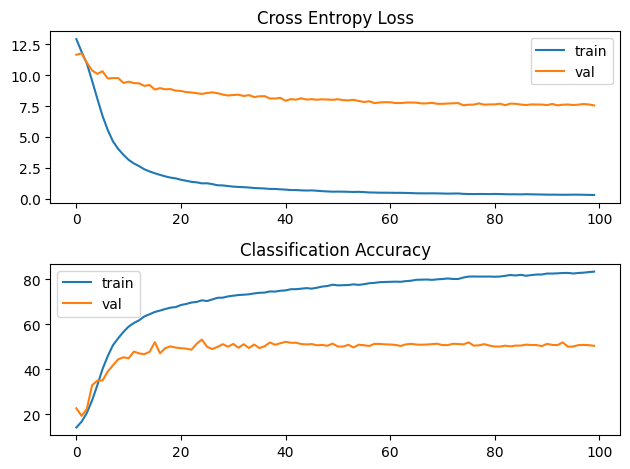

In [15]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [16]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
def test(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*12
        preds.extend(predsTmp.round().astype(int).squeeze())
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu().detach().numpy()
        labels.extend(original_values)
    print(labels[:1],preds[:1])
    preds_np = np.array(preds)
    labels_np = np.array(labels)
    matches = (preds_np == labels_np)
    accuracy = np.mean(matches) * 100
    return accuracy
test_loss = test(test_dataloader)
print(f"Test loss: {test_loss:.3f}")

100%|██████████| 142/142 [00:14<00:00,  9.87it/s]

[array([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  8,  9, 11, 10,  9,  8,  7])] [array([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  8,  9, 11, 10,  9,  8,  7])]
Test loss: 47.867


  0%|          | 0/142 [00:00<?, ?it/s]

[[ 1.  2.  3.  5.  4.  3.  2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.]
 [ 7.  8.  9. 11. 10.  9.  8.  7.]]
[[ 1  2  3  5  4  3  2  1]
 [ 0  0  0  0  0  0  0  0]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  6]
 [ 7  8  9 11 10  9  8  7]]


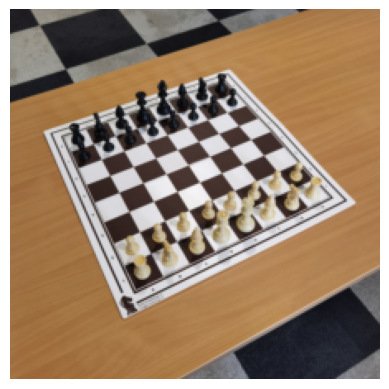

  0%|          | 0/142 [00:00<?, ?it/s]


In [17]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        predsTmp = pred.cpu().detach().numpy()*12
        print(predsTmp[0].round().reshape(8, 8))
        print(y.cpu()[0].reshape(8, 8).numpy())
        #print(pred.cpu())
        #print(y.cpu())
        original_values =y.cpu()
        labels.extend(original_values)
        imgs = X.cpu()
        imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
        plt.imshow(imgs[0])
        plt.axis('off')
        plt.show()
        break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?